# Changes in Leeds Property Prices During the Covid-19 Pandemic

This notebook is a rough and ready exploration of property price changes in Leeds, UK, during the Covid-19 pandemic.

If you care about truth, science, and all that stuff, then the following provisos are important:

- Many price predictors are missing: 
    - number of bedrooms
    - garden size
    - standard vs. non-standard construction
    - resident rats per square metre
    - etc.

- Many macro predictors are also missing:
    - Bank of England interest rate vs. time
    - buy-to-let tax rule changes
    - monetary inflation

- A fundamental understanding of the basic ontology of the system (allowing for a Bayesian approach with priors) is almost always preferable to blindly-applied frequentist stats in my firm opinion. Sometimes though, brute force stats is fun!
- No attempt is made to account for causal relationships between variables (like drawing a DAG), and this probably matters a lot for this data.
- No attempt is made to infer what was *causing* price changes; only *whether* statistically-significant price changes occurred.

In [29]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime

# force full-width display if viewed in Chrome browser
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# suppress SettingWithCopyWarning
pd.options.mode.chained_assignment = None

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('max_colwidth', 400)

np.set_printoptions(edgeitems=30, linewidth=100000)

## 1. Download UK Land Registry price-paid data and create bigquery dataset

In [64]:
# download data to the VM from source: https://www.gov.uk/government/statistical-data-sets/price-paid-data-downloads
!wget http://prod.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com/pp-complete.csv

# move to gcp bucket
!gsutil mv pp-complete.csv gs://housingasodhfmq349p78vp57pasvpfphio/pp-complete.csv
       
# make bigquery database called 'housing'
!bq mk housing

# create table called 'pricepaid' in housing database
!bq load --source_format=CSV \
housing.pricepaid gs://housingasodhfmq349p78vp57pasvpfphio/pp-complete.csv \
trans_id:STRING,price:INTEGER,date:STRING,postcode:STRING,type:STRING,newbuild:STRING,tenure:STRING,paon:STRING,saon:STRING,street:STRING,locality:STRING,town_city:STRING,district:STRING,county:STRING,ppd_type:STRING,record_status:STRING

In [65]:
!wget https://www.freemaptools.com/download/full-uk-postcodes/ukpostcodes.zip
!unzip ukpostcodes.zip
postcodes = pd.read_csv('ukpostcodes.csv')

In [67]:
!bq load --source_format=CSV \
housing.pricepaid gs://housingasodhfmq349p78vp57pasvpfphio/pp-complete.csv \
trans_id:STRING,price:INTEGER,date:STRING,postcode:STRING,type:STRING,newbuild:STRING,tenure:STRING,paon:STRING,saon:STRING,street:STRING,locality:STRING,town_city:STRING,district:STRING,county:STRING,ppd_type:STRING,record_status:STRING

## 2. Query data (Leeds only)

In [31]:
%%bigquery df

SELECT * FROM housing.pricepaid
WHERE town_city = 'LEEDS'

Downloading: 100%|██████████| 305373/305373 [00:02<00:00, 144172.39rows/s]


## 3. Inspect dataframe

In [32]:
df

,trans_id,price,date,postcode,type,newbuild,tenure,paon,saon,street,locality,town_city,district,county,ppd_type,record_status
0,{AC07BBD0-A011-0445-E053-6C04A8C01E31},382500,2020-05-01 00:00,LS17 8GD,D,N,F,6,,BRANDON CLOSE,,LEEDS,LEEDS,WEST YORKSHIRE,A,A
1,{3BD53B87-79D7-4303-B999-6C57ACE3C713},492000,2006-12-15 00:00,LS17 9BE,D,N,F,25,,FIRST AVENUE,BARDSEY,LEEDS,LEEDS,WEST YORKSHIRE,A,A
2,{4719B1E6-26CC-4F18-818B-73A1A19D5054},167950,2006-11-29 00:00,LS5 3NW,D,N,F,11,,VESPER COURT,LEEDS,LEEDS,LEEDS,WEST YORKSHIRE,A,A
3,{CD1BB411-D90D-4F60-83FC-97B03877A38F},125000,2003-04-23 00:00,LS25 2DD,D,N,F,74,,COTSWOLD DRIVE,GARFORTH,LEEDS,LEEDS,WEST YORKSHIRE,A,A
4,{FBBB1D15-5453-4493-A329-D06B7459201A},240000,1998-07-15 00:00,LS6 4EE,D,N,F,41,,GROVE ROAD,HEADINGLEY,LEEDS,LEEDS,WEST YORKSHIRE,A,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305368,{2A289E9D-C89D-CDC8-E050-A8C063054829},96995,2001-09-07 00:00,LS25 5PZ,T,Y,F,7,,MULBERRY COURT,SOUTH MILFORD,LEEDS,SELBY,NORTH YORKSHIRE,A,A
305369,{5CF9903C-52BF-7F13-E053-6C04A8C074B1},150000,2017-09-22 00:00,LS25 5PN,T,N,F,3,,CHESTNUT GREEN,MONK FRYSTON,LEEDS,SELBY,NORTH YORKSHIRE,A,A
305370,{B2E0DEBE-62AA-448E-8D06-1CC7DC6320EF},152000,2011-10-28 00:00,LS25 5AR,T,N,F,7A,,LOW STREET,SOUTH MILFORD,LEEDS,SELBY,NORTH YORKSHIRE,A,A
305371,{5F54B81E-2FDB-2B45-E053-6B04A8C01FB0},106000,2017-06-30 00:00,LS25 6GE,T,N,F,43,,BRUNSWICK CRESCENT,SHERBURN IN ELMET,LEEDS,SELBY,NORTH YORKSHIRE,B,A


In [33]:
# how many unique values are in each column?
df.nunique()

trans_id         305373
price             12172
date               7750
postcode          14095
type                  5
newbuild              2
tenure                3
paon               6238
saon               2357
street             8975
locality            121
town_city             1
district             11
county                4
ppd_type              2
record_status         1
dtype: int64

In [34]:
# check data types
df.dtypes

trans_id         object
price             int64
date             object
postcode         object
type             object
newbuild         object
tenure           object
paon             object
saon             object
street           object
locality         object
town_city        object
district         object
county           object
ppd_type         object
record_status    object
dtype: object

## 4. Pre-processing / clean-up

#### 4a. Postcode

In [35]:
# Some rows have missing postcodes
len(df[df['postcode'] == ''])

204

In [36]:
# Check for null entries in postcode column
len(df[df['postcode'].isnull()])

0

In [37]:
# Discard rows with empty string postcodes 
df = df[df['postcode'] != '']

In [38]:
# Check that all postcodes have space
len(df[df['postcode'].str.contains(' ')]) == len(df)

True

In [39]:
# Break down postcodes into components: area, district, sector ,and unit. 
def get_postcode_components(postcode):
    
    """
    Returns part of all of a postcode string resolved into area, district, sector or unit. 
    
    UK postcodes take any of the following formats, where A denotes alphabetical
    and N denotes numeric:
    
    AN NAA 
    ANN NAA
    AAN NAA
    AANN NAA
    ANA NAA
    AANA NAA
    
    (source: https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/611951/Appendix_C_ILR_2017_to_2018_v1_Published_28April17.pdf)
    
    - Area is the leftmost substring of alpha characters until (and excluding) a numeric character .Format: A or AA.
    - District is the substring commencing with numeric after the area, and before the space. Format: N, NN, or NA.
    - Sector is the first numeric character after the space. Format: N.
    - Unit is the rightmost substring. Format: AA.
   
    e.g.:
    >> get_postcode_component('RG40 2WD', component='sector')
    >> 2   
    
    e.g. 2:
    >> get_postcode_component('EC1A 3HX', component='area')
    >> EC
    
    e.g. 3:
    >> get_postcode_component('EC1A 3HX', component='district')
    >> 1A
    """
    
    # e.g. EC1A 3HX
    area_and_district = postcode.split(' ')[0] # EC1A
    sector_and_unit = postcode.split(' ')[1] # 3HX
        
    for index, char in enumerate(area_and_district):
        if char.isnumeric():
            area = area_and_district[:index] # EC
            district = area_and_district[index:] #1A
            break

    for index, char in enumerate(sector_and_unit):
        if char.isnumeric():
            unit = sector_and_unit[index+1:] # 3
            sector = sector_and_unit[:index+1] # HX
            break
    
    return dict({'area':area,
                 'district':district,
                 'sector':sector,
                 'unit':unit}
               )


# tests
test_postcodes = ['A1 2BC', 'A12 3BC', 'AB1 2BC', 'AB12 3CD', 'A1B 2BC', 'AB1C 2DE']
for postcode in test_postcodes:
    print(postcode, get_postcode_components(postcode))

A1 2BC {'area': 'A', 'district': '1', 'sector': '2', 'unit': 'BC'}
A12 3BC {'area': 'A', 'district': '12', 'sector': '3', 'unit': 'BC'}
AB1 2BC {'area': 'AB', 'district': '1', 'sector': '2', 'unit': 'BC'}
AB12 3CD {'area': 'AB', 'district': '12', 'sector': '3', 'unit': 'CD'}
A1B 2BC {'area': 'A', 'district': '1B', 'sector': '2', 'unit': 'BC'}
AB1C 2DE {'area': 'AB', 'district': '1C', 'sector': '2', 'unit': 'DE'}


In [40]:
# create new columns with postcode components
df['postcode_area'] = df['postcode'].apply(lambda x: get_postcode_components(x)['area'])
df['postcode_district'] = df['postcode'].apply(lambda x: get_postcode_components(x)['district'])
df['postcode_sector'] = df['postcode'].apply(lambda x: get_postcode_components(x)['sector'])
df['postcode_unit'] = df['postcode'].apply(lambda x: get_postcode_components(x)['unit'])

#### 4b. Date

In [41]:
# convert dates to timestamp and discard meaningless 00:00 hours/minutes data
df['date'] = df['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M'))

# sort by date
df = df.sort_values(by='date')

#### 4c. Various

In [42]:
# rename column to avoid keyword clash
df.rename(columns={'type': 'property_type'}, inplace=True)

# convert to lower case
df['street'] = df['street'].str.lower()
df['locality'] = df['locality'].str.lower()
df['town_city'] = df['town_city'].str.lower()
df['county'] = df['county'].str.lower()
df['district'] = df['district'].str.lower()

# convert letter codes to words for easier viewing/understanding
df['newbuild'] = df['newbuild'].apply(lambda x: 'newbuild' if x=='Y' else ('oldbuild' if x=='N' else x))
df['tenure'] = df['tenure'].apply(lambda x: 'freehold' if x=='F' else('leasehold' if x=='L' else 'unknown'))
df['property_type'] = df['property_type'].apply(lambda x: 'detached' if x=='D' else ('semi' if x=='S' else('terraced' if x=='T' else ('flat' if x=='F' else 'other'))))

# drop uninteresting columns
df = df.drop('ppd_type', axis=1)
df = df.drop('record_status', axis=1)

## 5. Prices over the last 20 years or so: quick inspection

In [43]:
#import matplotlib.dates as mdates 
from matplotlib.dates import MonthLocator


def filter_by(dataframe, **kwargs):
    
    """
    Function to filter dataframe by whatever choice of variables
    
    numerical keys:  min_price, max_price, min_date, max_date
    
    e.g.:
    
    results = filter_by(dataframe=df,
                        property_type='terraced',
                        postcode_sector='LS13 2',
                        min_price=0,
                        max_price=280000,
                        min_date='2017-06-01', 
                        )
    """
    
    for key, value in kwargs.items():        
            # numerical variables that require a range
            if key == 'min_price':
                dataframe = dataframe[dataframe['price'] >= value]
            elif key == 'max_price':
                dataframe = dataframe[dataframe['price'] <= value]                
            elif key == 'min_date':
                dataframe = dataframe[dataframe['date'] >= value]
            elif key == 'max_date':
                dataframe = dataframe[dataframe['date'] <= value]
            # categorical variables
            else:
                dataframe = dataframe[dataframe[key] == value]

    return dict({'dataframe': dataframe, 'filters': dict(kwargs.items())})


def graph(dataframe_and_filters):

    """
    Plots price vs. date using filtered dataframe 
    Takes dictionary with keys 'dataframe' and 'filters' output by filter_by()
    
    """
    
    dataframe = dataframe_and_filters['dataframe'] 
    filters = dataframe_and_filters['filters'] 
    
    fig, ax = plt.subplots(1, 1)
    fig.set_figheight(10)
    fig.set_figwidth(10)
    
    # moving price average
    dataframe['moving_average_price'] = dataframe['price'].rolling(window=100).mean()
    
    ax.xaxis.set_major_locator(MonthLocator(bymonth=1))
    ax.tick_params(axis='x', labelrotation=30)
    
    ax.set_xlabel('date')
    ax.set_title(f'Price vs. date for properties filtered by: \n{[(key, value) for (key, value) in filters.items()]}')
    ax.set_ylabel('price / £')
    
    ax.scatter(dataframe['date'], dataframe['price'], alpha=0.1, label='sale prices')
    ax.plot(dataframe['date'], dataframe['moving_average_price'], label='100-transaction moving average sale price')
    ax.legend()


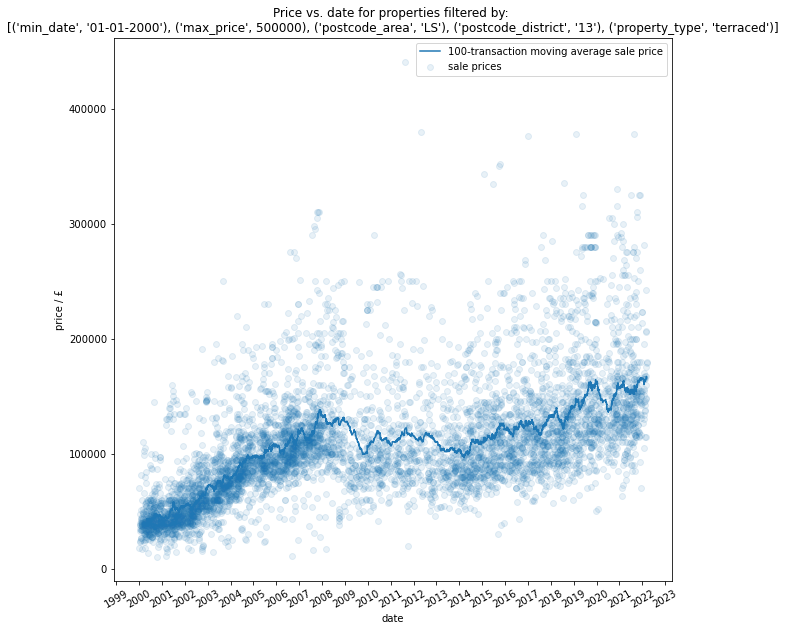

In [44]:
df_ = filter_by(dataframe=df,
                min_date='01-01-2000',
                max_price=500000,
                postcode_area='LS',
                postcode_district='13',
                property_type='terraced'
               )

graph(df_)

Well that's no surprise. The 2008 crash shows up clearly with drops in price and volume. The 2009-2014 bear market and subsequent 2015- bull market and Covid-19 surge of 2021 are evident. There's also a large spread in prices since the geographic area LS13 is a fairly large and diverse postcode. Oh, and I've not accounted for inflation.

# 6. Did certain types of properties undergo larger price changes than others during the pandemic?

I had a hunch that certain types of properties had increased in price more than others over the period of summer 2020 to summer 2022. From browsing Zoopla, my hunch was that 3-bed semis in "average" areas like Middleton or Bramley tended to sell at ~£130,000 in summer 2020, and seemed to climb to  around ~£180,000 in summer 2022. Whereas detached 3-beds in nicer places like New Farnley seemed to be around ~£220,000 in summer 2020, and didn't seem to move much in price by summer 2022.

I speculated that one of the many causal factors behind such price-dependence of price changes might be because 3-bed semis in the £130k - £180k range are affordable to the median buyer. The median salary in Leeds was about £35,900 in 2021 and lenders' limit tends to be about four times income, meaning a lending limit of somewhere around £145,000. If you're looking for a 3-bed semi in Middleton, you're probably a first-time or second-time buyer, so you probably don't have a huge deposit or existing equity. Perhaps demand was therefore high in this lower £130,000 - £180,000 range because lots of people could afford it, but less so around £220,000 because it's getting too expensive for the median buyer.

Whatever. Let's do some crude, brute-force stats and look at the trends.

## 6a. Simple two-variable (price vs. time) ordinary least squares linear regression approach controlling for other variables

My hunch described above translates well into a linear regression problem with a single target variable (price), single predictor (date), controlled w.r.t. other variables like postcode and property type.

Psychologically, I think the pandemic really started in March 2020 when lockdowns and the furlough scheme started, so let's pick 1st March 2020 as the start date for the analysis.

In [45]:
# focus on transactions from 1st March 2020 to 1st March 2022
start_date = datetime(2020, 3, 1)
end_date = datetime(2022, 3, 1)

df_ = filter_by(dataframe=df,
                min_date=start_date.strftime('%d-%m-%Y'),
                max_date=end_date.strftime('%d-%m-%Y'))['dataframe']

# convert date column to number of days since 1st March 2020 for linear regression 
df_['days'] = df_['date'].apply(lambda x: (x - start_date).days)

# decide on the control variables used to stratify the dataframe into smaller dataframes
control_variables = ['property_type', 'postcode_area', 'postcode_district']

# store the resultant stratified dataframes as a list
groups = list(df_.groupby(control_variables)[['price', 'date']])

print('number of groups: ', len(groups))

number of groups:  112


It's worth having a quick inspection of the group sizes that result from the choice of control variables:

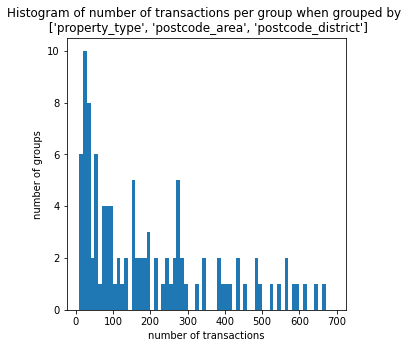

In [46]:
# number of transactions in each group
group_sizes = [len(group[1]) for group in groups]

plt.rcParams["figure.figsize"]=(5,5)
plt.title(f'Histogram of number of transactions per group when grouped by \n {control_variables}')
plt.xlabel('number of transactions')
plt.ylabel('number of groups')
#plt.yscale('log')
plt.hist(group_sizes, bins=np.arange(10, max(group_sizes), 10));

Depending on the choice of control variables above, this generally looks a bit like (but isn't necessarily) a Pareto distribution, meaning that any pairwise comparisons across a given grouping (e.g. semi-detached newbuild freehold houses in LS6 2xx  vs. newbuild freehold flats in LS9 1xx) involves two key considerations:
- highly variable sample sizes
- small samples sizes in some cases

OK, well, one way to deal with these two factors is to *assume* (assume being the important word) that the relationship between price and date is linear, then calculate the gradient of price vs. time, using the standard error on the gradient. This way, sample size variation is naturally encoded in the standard error intervals allowing any uncertainty to be incorporated into the subsequent analysis. This uncertainty is only meaningful to the extend that the assumption of linearity is valid. In reality, many unaccounted factors influence the price changes.

Additionally, it makes sense to normalise the price in each group by some reference value. This is because price changes will generally be in proportion to the price itself, and we want to compare price changes across groups. I'll take the average price for each group as the reference for pragmatism's sake. 

In [47]:
import traceback
import statsmodels.api as sm

# for each grouping, calculate the normalised price vs. time gradient
for group in groups:
    
    # get dimensionless price measured in £/£ by dividing by the mean price in that group
    group[1]['price_norm'] = group[1]['price'] / group[1]['price'].sum()
    
    x = group[1]['days']
    y = group[1]['price']
    y_norm = group[1]['price_norm']
    
    # gradients are ill-defined if there's only one transaction in the group
    try:
        # get OLS best fit line for price vs. time
        model = sm.OLS(y,x)
        results = model.fit()
        gradient = results.params.days
        stderr = results.bse.days
        
        # get OLS best fit line for normalised price vs. time
        model_norm = sm.OLS(y_norm,x)
        results_norm = model_norm.fit()
        gradient_norm = results_norm.params.days
        stderr_norm = results_norm.bse.days
    
        # create new columns containing gradients and their standard errors
        group[1]['price_gradient'] = gradient
        group[1]['stderr'] = stderr
        group[1]['price_gradient_norm'] = gradient_norm
        group[1]['stderr_norm'] = stderr_norm
        
    except Exception:
        traceback.print_exc()
        
    # convenience column to help with subsequent clean-up
    group[1]['grouping'] = str(group[0])

/opt/conda/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/opt/conda/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


In [48]:
# recombine dataframes into one
results = pd.concat([group[1] for group in groups])

# drop other columns and remove duplicates
results.drop(results.columns.difference(control_variables +
                                        ['price_gradient',
                                         'stderr',
                                         'price_gradient_norm',
                                         'stderr_norm',
                                         'grouping',
                                        ]
                                       ), 
             axis=1,
             inplace=True
            )

results = results.drop_duplicates().reset_index(drop=True)

# replace any infinite gradients with nan
results.replace([np.inf, -np.inf], np.nan, inplace=True)

# remove ill-defined gradients, so drop these rows
results = results.dropna()

# sort by gradient
results = results.sort_values(by='price_gradient', ascending=True)

In [49]:
results.head(5)

,property_type,postcode_area,postcode_district,price_gradient,stderr,price_gradient_norm,stderr_norm,grouping
104,terraced,LS,28,-10117.187500,1445.312500,-0.031250,4.464286e-03,"('terraced', 'LS', '28')"
65,other,LS,7,188.936684,64.323781,0.000008,2.850578e-06,"('other', 'LS', '7')"
90,terraced,LS,11,226.835731,5.971796,0.000004,1.040554e-07,"('terraced', 'LS', '11')"
111,terraced,LS,9,234.844811,9.987571,0.000004,1.840659e-07,"('terraced', 'LS', '9')"
26,flat,LS,13,245.620408,16.272743,0.000026,1.725694e-06,"('flat', 'LS', '13')"


## 6b. Plot results

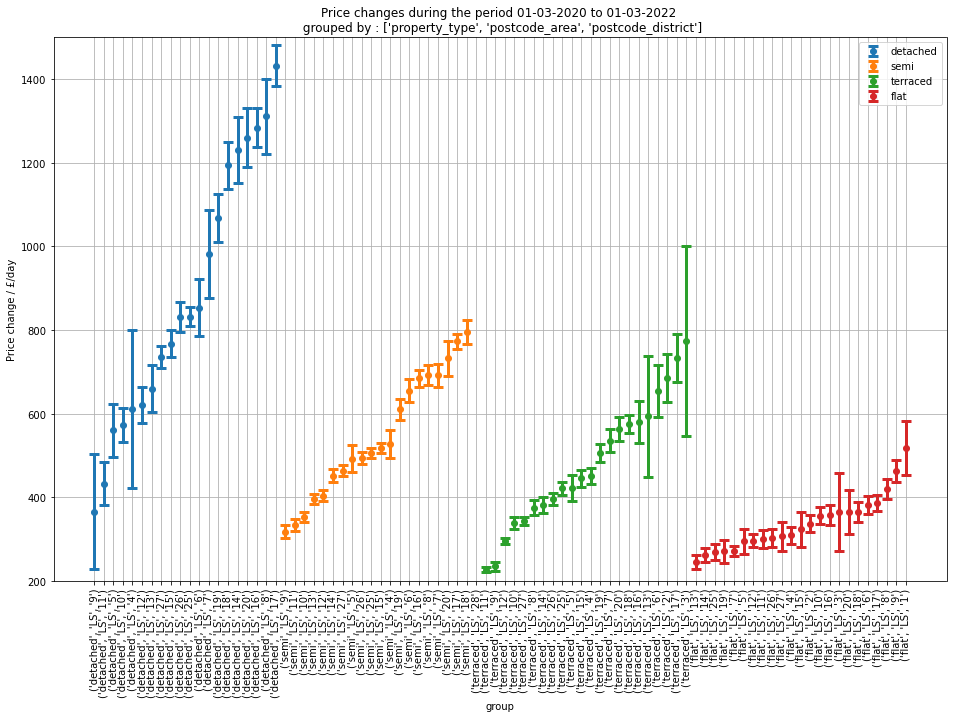

In [50]:
y_d = results[results['property_type'] == 'detached']['price_gradient']
x_d = results[results['property_type'] == 'detached']['grouping']
stderrs_d = results[results['property_type'] == 'detached']['stderr']

y_t = results[results['property_type'] == 'terraced']['price_gradient']
x_t = results[results['property_type'] == 'terraced']['grouping']
stderrs_t = results[results['property_type'] == 'terraced']['stderr']

y_s = results[results['property_type'] == 'semi']['price_gradient']
x_s = results[results['property_type'] == 'semi']['grouping']
stderrs_s = results[results['property_type'] == 'semi']['stderr']

y_o = results[results['property_type'] == 'flat']['price_gradient']
x_o = results[results['property_type'] == 'flat']['grouping']
stderrs_o = results[results['property_type'] == 'flat']['stderr']

fig, ax = plt.subplots(1, 1)
fig.set_figheight(10)
fig.set_figwidth(16)

ax.tick_params(axis='x', labelrotation=90)

ax.set_xlabel('group')
ax.set_title(f'Price changes during the period {start_date.strftime("%d-%m-%Y")} to {end_date.strftime("%d-%m-%Y")} \n grouped by : {control_variables}')
ax.set_ylabel('Price change / £/day')
#ax.set_yscale('log')

ax.set_ylim([200, 1500])
ax.grid()

ax.errorbar(x_d, y_d, yerr=stderrs_d, fmt='o', elinewidth=3, capthick=3, capsize=5, label='detached')
ax.errorbar(x_s, y_s, yerr=stderrs_s, fmt='o', elinewidth=3, capthick=3, capsize=5, label='semi')
ax.errorbar(x_t, y_t, yerr=stderrs_t, fmt='o', elinewidth=3, capthick=3, capsize=5, label='terraced')
ax.errorbar(x_o, y_o, yerr=stderrs_o, fmt='o', elinewidth=3, capthick=3, capsize=5, label='flat')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels);

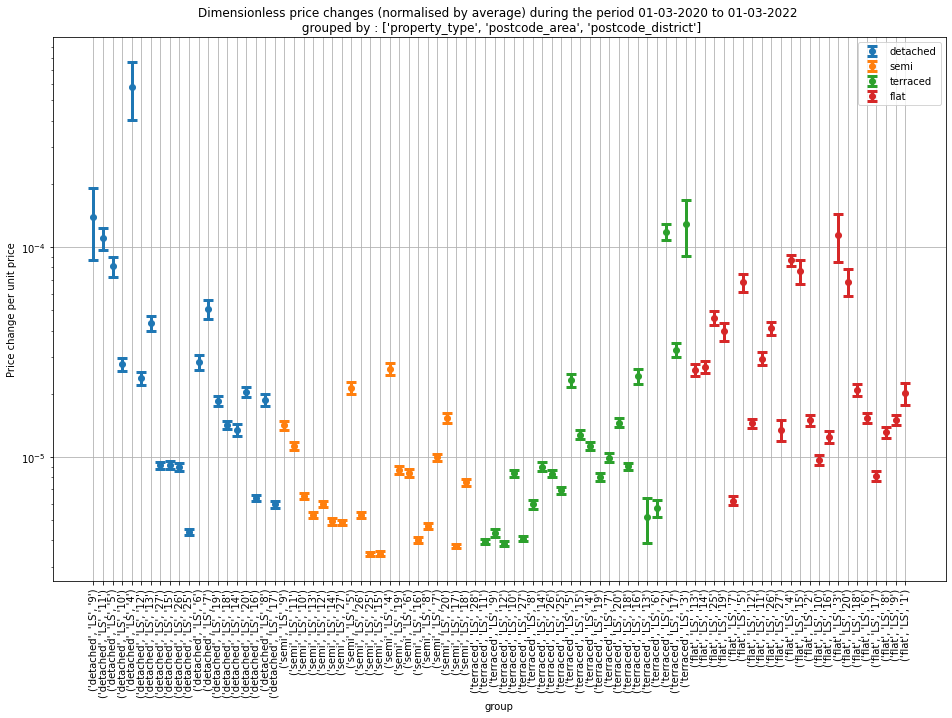

In [51]:
y_d = results[results['property_type'] == 'detached']['price_gradient_norm']
x_d = results[results['property_type'] == 'detached']['grouping']
stderrs_d = results[results['property_type'] == 'detached']['stderr_norm']

y_t = results[results['property_type'] == 'terraced']['price_gradient_norm']
x_t = results[results['property_type'] == 'terraced']['grouping']
stderrs_t = results[results['property_type'] == 'terraced']['stderr_norm']

y_s = results[results['property_type'] == 'semi']['price_gradient_norm']
x_s = results[results['property_type'] == 'semi']['grouping']
stderrs_s = results[results['property_type'] == 'semi']['stderr_norm']

y_o = results[results['property_type'] == 'flat']['price_gradient_norm']
x_o = results[results['property_type'] == 'flat']['grouping']
stderrs_o = results[results['property_type'] == 'flat']['stderr_norm']

fig, ax = plt.subplots(1, 1)
fig.set_figheight(10)
fig.set_figwidth(16)

ax.tick_params(axis='x', labelrotation=90)

ax.set_xlabel('group')
ax.set_title(f'Dimensionless price changes (normalised by average) during the period {start_date.strftime("%d-%m-%Y")} to {end_date.strftime("%d-%m-%Y")} \n grouped by : {control_variables}')
ax.set_ylabel('Price change per unit price')
ax.set_yscale('log')

#ax.set_ylim([200, 1500])
ax.grid()

ax.errorbar(x_d, y_d, yerr=stderrs_d, fmt='o', elinewidth=3, capthick=3, capsize=5, label='detached')
ax.errorbar(x_s, y_s, yerr=stderrs_s, fmt='o', elinewidth=3, capthick=3, capsize=5, label='semi')
ax.errorbar(x_t, y_t, yerr=stderrs_t, fmt='o', elinewidth=3, capthick=3, capsize=5, label='terraced')
ax.errorbar(x_o, y_o, yerr=stderrs_o, fmt='o', elinewidth=3, capthick=3, capsize=5, label='flat')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels);